# Project 1 
#### by Fabio, Ivan and Olivier

## Data Import

In [229]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

# Loading training data
y, tX, ids = load_csv_data('data/train.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

Removing the column PRI_jet_num (23rd) since it is not relevant for the prediction

In [ ]:
tX = np.delete(tX, 22, axis=1)

Remove all features that have a given amount of undefined (-999) entries.

In [235]:
TRESHOLD = 150000
j = 0
for i in range(len(tX[0])):
    occurrences = np.count_nonzero(tX[:,j] == -999)
    if occurrences > 0:
        print("Feature", i, "has", occurrences, "undefined entries")
    if occurrences > TRESHOLD:
        tX = np.delete(tX, j, axis=1)
    else: j = j + 1

Feature 0 has 38114 undefined occurences.
Feature 19 has 99913 undefined occurences.
Feature 20 has 99913 undefined occurences.
Feature 21 has 99913 undefined occurences.


#### Takeaways
It boosts performance if we remove features that have more than 177456 undefined values which is more than 70%. 
It decreases performance if we remove features that have less than 99913 undefined values.
--> We need to find try and change the undefined values (-999) to different values like the mean or zero.
--> We should especially look into the feature 'DER_mass_MMC' that has 38114 undefined values and a high feature importance (see chart below)

In [ ]:
#tX = tX[tX == np.float64(-999.0)] = np.float64(0.0) #work in progress

In [202]:
tX = standardize(tX)

In [203]:
# Choosing a polynomial basis
#tX = polynomial_basis(tX, [1, 2], std=True)

In [204]:
# Splitting dataset into train and validation sets
ratio = 0.8  # Ratio of samples to use in new train set
cut_off_point = int(ratio*len(y))
np.random.seed(0)  # Fixing a seed for reproducibility
rand_ind = np.random.permutation(np.arange(len(y)))
y_train, y_valid = y[cut_off_point:], y[:cut_off_point]
tX_train, tX_valid = tX[cut_off_point:], tX[:cut_off_point]

## Visualizations

In [171]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

In [98]:
print(y.shape, tX.shape, ids.shape)
data = pd.read_csv('data/train.csv')
data.head(5)

(250000,) (250000, 29) (250000,)


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [99]:
data.describe()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


### Correlation Matrix

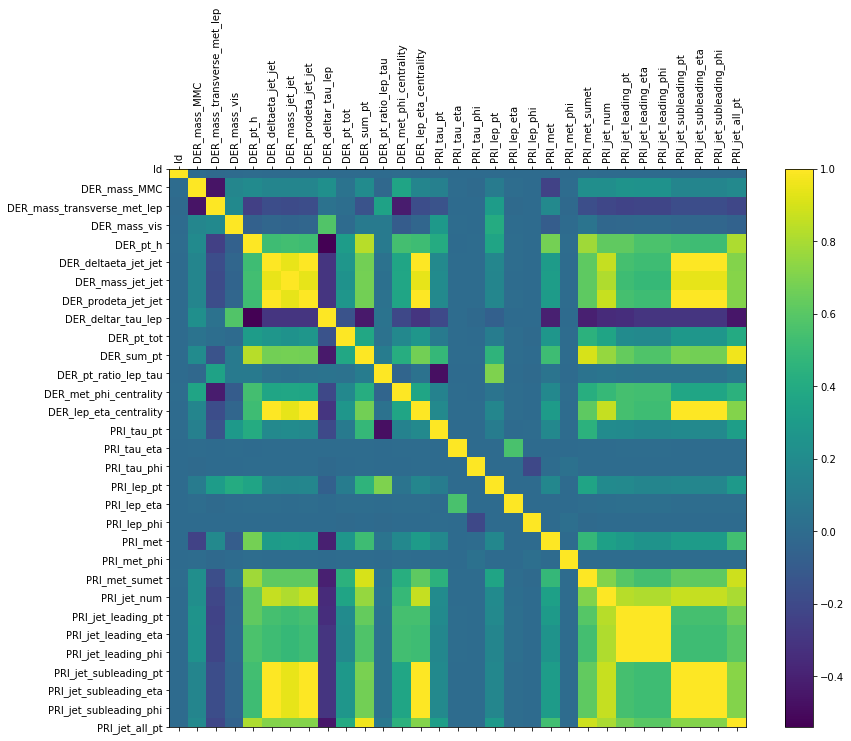

In [100]:
f = plt.figure(figsize=(14, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns)
cb = plt.colorbar()

### Get the most important features

/Users/olivierstaehli/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09350241 0.07983144 0.05725161 0.03321462 0.01440074 0.01455481
 0.01747993 0.05501585 0.03163675 0.0419157  0.0483631  0.07201514
 0.02183116 0.05520165 0.03146414 0.02662658 0.03490695 0.0327629
 0.027089   0.04119722 0.02756303 0.02891227 0.00866731 0.01729801
 0.0280898  0.02016418 0.00662211 0.00829312 0.00696919 0.01715926]


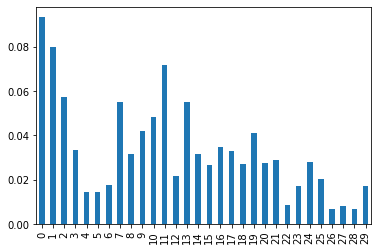

In [44]:
model = ExtraTreesClassifier()
model.fit(tX,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_)
feat_importances.plot(kind='bar')
plt.show()

Visualize feature correlation

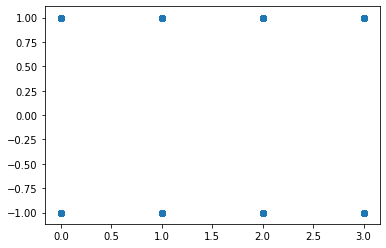

In [90]:
x = data['PRI_jet_num'] #enter any feature to check for correlation to label.
plt.scatter(x, y) 
plt.plot()
plt.show()

Visualization of the predictions to show if the data set is balanced. Since we have a slightly unbalanced dataset we will evaluate the performance with the F1-Score which is a more telling method for evaluation.

Ratio: 0.521


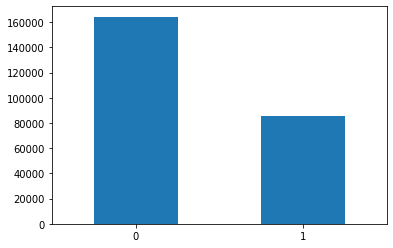

In [46]:
count = collections.Counter(y)
balance = [count[-1], count[1]]
vis = pd.Series(balance, index=range(len(balance)))
vis.plot(kind="bar", rot=0)
plt.plot()
print("Ratio:", round(count[1]/count[-1],3))

## Scoring functions

In [205]:
def f1_score(y_valid, tX_valid, weights):
    """
    Return the F1-score achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for 'Precision and recall'
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for 'F-score'
        https://en.wikipedia.org/wiki/F-score

    """

    # Number of samples
    N = len(y_valid)

    # Obtaining the predictions
    y_pred = predict_labels(weights, tX_valid)

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)

    f1 = np.round(2 * precision * recall / (precision + recall), 4)

    return f1

In [206]:
def accuracy(y_valid, tX_valid, weights):
    """
    Return the accuracy achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    acc : float
        Accuracy for this configuration (the closer to 1 the better)

    References
    ----------
    [3] Wikipedia entry for 'Accuracy and precision'
        https://en.wikipedia.org/wiki/Accuracy_and_precision

    """

    # Number of samples
    N = len(y_valid)

    # Obtaining the predictions
    y_pred = predict_labels(weights, tX_valid)

    # Calculating number of true positives and negatives
    num_tp_tn = np.sum(y_valid == y_pred)

    acc = np.round(num_tp_tn / N, 4)

    return acc

## Regressors

### 1. Least squares gradient descent

In [207]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 1000
gamma = 0.01

# Fitting
start = time.time()
weights, loss = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_GD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_GD': accuracy = ", acc)

Execution time: 1.5297 sec
F1-score achieved with 'least_squares_GD': F1 =  0.6585
Accuracy achieved with 'least_squares_GD': accuracy =  0.7066


 ### 2. Least squares stochastic gradient descent

In [208]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 1000
gamma = 0.1

# Fitting
start = time.time()
weights, loss = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_SGD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_SGD': accuracy = ", acc)

Execution time: 0.0211 sec
F1-score achieved with 'least_squares_SGD': F1 =  0.4949
Accuracy achieved with 'least_squares_SGD': accuracy =  0.5817


### 3. Least squares (normal equation)

In [209]:
# Fitting
start = time.time()
weights, loss = least_squares(y_train, tX_train)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares': F1 = ", f1)
print("Accuracy achieved with 'least_squares': accuracy = ", acc)

Execution time: 0.0049 sec
F1-score achieved with 'least_squares': F1 =  0.6595
Accuracy achieved with 'least_squares': accuracy =  0.7068


### 4. Ridge regression (for least square normal equation)

In [210]:
# Hyperparameters
# TODO: test different values of lambda
lambda_ = 0.001

# Fitting
start = time.time()
weights, loss = ridge_regression(y_valid, tX_valid, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'ridge_regression': F1 = ", f1)
print("Accuracy achieved with 'ridge_regression': accuracy = ", acc)

Execution time: 0.0474 sec
F1-score achieved with 'ridge_regression': F1 =  0.6593
Accuracy achieved with 'ridge_regression': accuracy =  0.7078


### 5. Logistic regression

In [211]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression': accuracy = ", acc)

Execution time: 1.1209 sec
F1-score achieved with 'logistic_regression': F1 =  0.4886
Accuracy achieved with 'logistic_regression': accuracy =  0.5761


### 5: Logistic regression (alternative)

In [212]:
def calculate_sigmoid(z):
    return 1/(1 + np.exp(-z))

In [213]:
def calculate_cost(y, tX, w):
    return 1/2 * np.sum((y-calculate_sigmoid(np.dot(tX, w)))**2)

In [214]:
def calculate_gradient(y, tX, w):   
    return np.dot(y-calculate_sigmoid(np.dot(tX, w)), tX)

In [215]:
def logistic_regression_alt(y, tX, initial_w, max_iters=100, gamma=0.01):
    w = initial_w
    loss = []
    for i in range(max_iters):
        random =  np.random.randint(0, len(y))
        w = w + gamma * calculate_gradient(y[random], tX[random], w)
        cost = calculate_cost(y, tX, w)
        loss.append(cost)
    return w, loss

In [216]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression_alt(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression_alt': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression_alt': accuracy = ", acc)

Execution time: 0.67 sec
F1-score achieved with 'logistic_regression_alt': F1 =  0.4982
Accuracy achieved with 'logistic_regression_alt': accuracy =  0.5862


### 6. Regularized logistic regression

In [217]:
# Hyperparameters
# TODO: test different values of gamma and lambda
lambda_ = 1
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'reg_logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'reg_logistic_regression': accuracy = ", acc)

Execution time: 1.1203 sec
F1-score achieved with 'reg_logistic_regression': F1 =  0.4825
Accuracy achieved with 'reg_logistic_regression': accuracy =  0.572


## Optimized Regressors

In [218]:
def f1_score_predictions(y_valid, y_pred):
    """
    Return the F1-score achieved with the predictions of a validation set
    
    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    y_pred : np.ndarray
        Vector containing the predictions.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for the Precision and recall
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for F-score
        https://en.wikipedia.org/wiki/F-score

    """

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)

    f1 = np.round(2 * precision * recall / (precision + recall),4)
    
    return f1

### Ensemble learner 1

In [219]:
def ensemble_learner1(y, tX, tX_valid, n_learners=10, ratio=0.5):
    """
    Supply 'n_learners' regressors with a random subset of size 'ratio' of the
    features. Majority vote for the prediction.
    """

    y_pred_final = np.zeros(len(y_valid))
    n_features = tX.shape[1]

    for i in range(n_learners):

        feature_indices = np.random.choice(np.arange(n_features), int(ratio*n_features))
        tX_slice = tX[:, feature_indices]
        weights, _ = reg_logistic_regression(y, tX_slice, 1, np.ones(tX_slice.shape[1], dtype=float), 100, 0.01)

        tX_valid_slice = tX_valid[:, feature_indices]
        y_pred = tX_valid_slice @ weights
        y_pred[np.where(y_pred <= 0)] = -1
        y_pred[np.where(y_pred > 0)] = 1

        y_pred_final += y_pred

    y_pred_final[np.where(y_pred_final <= 0)] = -1
    y_pred_final[np.where(y_pred_final > 0)] = 1

    return y_pred_final

In [220]:
# Fitting
start = time.time()
y_pred = ensemble_learner1(y, tX, tX_valid, n_learners=10, ratio=0.3)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score_predictions(y_valid, y_pred)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

Execution time: 4.1693 sec
F1-score achieved with 'logistic_regression': F1 =  0.4696


### Ensemble learner 2

In [221]:
def ensemble_learner2(y, tX, tX_valid, n_learners=10, ratio=0.5):
    """
    Supply 'n_learners' regressors with a random subset of size 'ratio' of the
    samples. Majority vote for the prediction.
    """

    y_pred_final = np.zeros(len(y_valid))
    n_samples = tX.shape[0]

    for i in range(n_learners):

        sample_indices = np.random.choice(np.arange(n_samples), int(ratio*n_samples))
        tX_slice = tX[sample_indices, :]
        y_slice = y[sample_indices]
        weights, _ = reg_logistic_regression(y_slice, tX_slice, 1, np.ones(tX_slice.shape[1], dtype=float), 100, 0.01)

        y_pred = tX_valid @ weights
        y_pred[np.where(y_pred <= 0)] = -1
        y_pred[np.where(y_pred > 0)] = 1

        y_pred_final += y_pred

    y_pred_final[np.where(y_pred_final <= 0)] = -1
    y_pred_final[np.where(y_pred_final > 0)] = 1

    return y_pred_final

In [222]:
# Fitting
start = time.time()
y_pred = ensemble_learner2(y, tX, tX_valid, n_learners=100, ratio=0.1)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score_predictions(y_valid, y_pred)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

Execution time: 10.2282 sec
F1-score achieved with 'logistic_regression': F1 =  0.4825


### Evaluation

In [66]:
y_pred = predict_labels(weights, tX_valid)
confusion_matrix(y_valid, y_pred)

array([[89563, 41933],
       [37196, 31308]])

## Lasso subgradient descent regressor

In [67]:
def lasso_SD(y, tX, initial_w, max_iters=100, gamma=0.1, lambda_ = 0.1, threshold=None):

    # Number of samples
    N = len(y)

    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((len(initial_w), 1))
    y = y.reshape((N, 1))

    # Checking if 'tX' is a 1D array, and consequently converting to a 2D array
    if len(tX.shape) == 1:

        tX = tX.reshape((N, 1))

    for iter in range(max_iters):

        # Error vector
        e = y - np.dot(tX, w)

        # Subgradient for the Lasso loss function
        subgrad = - np.dot(tX.T, e) / N + lambda_ * np.sign(w)

        # Updating weights with negative gradient scaled by 'gamma'
        w = w - gamma * subgrad


    # Computing loss (MSE) for the weights in the final iteration
    loss = np.mean(e**2) / 2

    # Converting weights back to 1D arrays
    w = w.reshape(len(w))

    # Setting to zero all the entries of w under the threshold in absolute value
    if (threshold != None):
        w[np.absolute(w) < threshold] = 0

    return w, loss

In [68]:
# Hyperparameters
# TODO: test different values of gamma and lambda
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 500
gamma = 0.1
lambda_ = 0.01
threshold = 0.05

# Fitting and scoring WITHOUT threshold
start = time.time()
weights, loss = lasso_SD(y_train, tX_train, initial_w, max_iters, gamma, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
print(np.sort(abs(weights)))

f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'lasso_GD', no threshold: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', no threshold: accuracy = ", acc, "\n\n")

# Fitting and scoring WITH threshold
start = time.time()
weights, loss = lasso_SD(y_train, tX_train, initial_w, max_iters, gamma, lambda_, threshold)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
print(np.sort(abs(weights)))
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'lasso_GD', no threshold: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', no threshold: accuracy = ", acc)

Execution time: 0.8961 sec
[8.36764000e-05 9.25633090e-05 3.05069276e-04 5.21845025e-04
 7.66605152e-04 8.97498174e-04 1.01743678e-03 1.09395406e-03
 1.52633214e-03 4.50869511e-03 6.62534048e-03 6.68757541e-03
 1.57746493e-02 1.76235239e-02 1.97265660e-02 3.19082853e-02
 3.38195852e-02 3.43614716e-02 5.00802455e-02 6.41135744e-02
 7.42650952e-02 1.08954064e-01 1.11093313e-01 1.12195614e-01
 1.60458477e-01 1.60614959e-01 1.66836390e-01 1.89871591e-01
 2.32807974e-01 2.40535652e-01]
F1-score achieved with 'lasso_GD', no threshold: F1 =  0.6618
Accuracy achieved with 'lasso_GD', no threshold: accuracy =  0.7131 


Execution time: 0.9598 sec
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.05008025 0.06411357 0.0742651  0.10895406 0.11109331 0.11219561
 0.16045848 0.16061496 0.16683639 0.18987159 0.23280797 0.24053565]
F1-score achieved with 'lasso_GD', no thre

## Mean Absolute Error subgradient regressor

In [72]:
def absolute_SD(y, tX, initial_w, max_iters=100, gamma=0.1):
    N = len(y) # Number of samples
    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((len(initial_w), 1))
    y = y.reshape((N, 1))
    if len(tX.shape) == 1: # Checking if 'tX' is a 1D array, and consequently converting to a 2D array
        tX = tX.reshape((N, 1))
    for iter in range(max_iters):
        e = y - np.dot(tX, w) # Error vector
        subgrad = - np.dot(tX.T, np.sign(e)) / N # Subgradient for the MAE loss function
        w = w - gamma * subgrad # Updating weights with negative gradient scaled by 'gamma'
    loss = np.mean(np.abs(e)) # Computing loss (MSE) for the weights in the final iteration
    w = w.reshape(len(w)) # Converting weights back to 1D arrays
    return w, loss

In [75]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 500
gamma = 0.1

# Fitting
start = time.time()
weights, loss = absolute_SD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'absolute_SD': F1 = ", f1)
print("Accuracy achieved with 'absolute_GD': accuracy = ", acc)

Execution time: 1.5612 sec
F1-score achieved with 'absolute_SD': F1 =  0.6386
Accuracy achieved with 'absolute_GD': accuracy =  0.7008


## Generate predictions and save ouput in csv format for submission

In [71]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

OSError:  not found.

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)